In [3]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.19.0'

# Models for classifiying cell type

## Problem statement

**Objective**:
The objective of this task is to classify cell type data, which consists of four distinct categories: a, b, c, and others. This problem is framed as a multi-class classification problem, where each sample (an image of a cell) must be assigned one of the four labels based on its features. The dataset is imbalanced, meaning certain classes have far fewer samples than others, which introduces challenges in model evaluation.

**Metric Selection**:
Given the class imbalance present in the dataset, accuracy alone is not a sufficient evaluation metric. In this context, the weighted F1 score is the preferred metric. The F1 score is the harmonic mean of precision and recall, and it balances these two metrics to provide a more comprehensive evaluation.
Since we have an imbalanced dataset, the weighted F1 score is particularly useful because it gives more weight to the larger classes while still considering performance on the smaller classes. This helps ensure that the model performs well across all classes, not just the majority class, and avoids the bias that could arise from imbalanced class distributions. The weighted F1 score is calculated by averaging the F1 scores of each class, weighted by the number of instances in that class. This approach ensures that the model’s performance on minority classes is not overlooked.

**Baseline Model**:
For a baseline model, we will start with a Random Forest classifier. Random Forest is chosen because it is a robust, interpretable model well-suited for classification tasks, and it performs well on medium-sized datasets. Random Forest does not require extensive hyperparameter tuning and can provide a solid baseline for comparison with more advanced models.

**Improvement through Neural Networks**:
To improve upon the baseline, we will experiment with Neural Networks (NN) and Convolutional Neural Networks (CNNs). Neural networks, particularly CNNs, are highly specialized for image classification tasks as they can automatically learn hierarchical features and patterns from image data. CNNs have been shown to outperform traditional machine learning models in many image-related tasks due to their ability to capture spatial relationships in images. These models are expected to provide a significant boost in performance compared to the Random Forest baseline.

## Baseline development

In [ ]:
# For the random forest classifier, as the image does not represent, so we need to extract the features for classifying.

In [32]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Function to load and preprocess image data
def load_and_extract_features(image_path, size=(27, 27)):
    """
    Load an image, resize it, and extract features using HOG and LBP
    """
    try:
        # Load image
        img = Image.open(image_path)
        
        # Resize image
        # img = img.resize(size)
        
        # Convert to numpy array
        img_array = np.array(img)
        
        # If image is grayscale, convert to RGB
        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,) * 3, axis=-1)
            
        # Convert to grayscale for feature extraction
        gray_img = rgb2gray(img_array)
        
        # Extract HOG features
        hog_features = hog(gray_img, 
                          orientations=9, 
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), 
                          visualize=False)
        
        # Extract LBP features
        lbp_features = local_binary_pattern(gray_img, P=8, R=1)
        lbp_hist, _ = np.histogram(lbp_features.flatten(), bins=np.arange(0, 10), density=True)
        
        # Basic statistical features
        red_channel = img_array[:,:,0].flatten()
        green_channel = img_array[:,:,1].flatten()
        blue_channel = img_array[:,:,2].flatten()
        
        color_stats = [
            np.mean(red_channel), np.std(red_channel),
            np.mean(green_channel), np.std(green_channel),
            np.mean(blue_channel), np.std(blue_channel)
        ]
        
        # Combine all features
        all_features = np.concatenate([hog_features, lbp_hist, color_stats])
        return all_features
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        # Return a vector of zeros in case of error
        return np.zeros(324) 

In [3]:
celltype_data = pd.read_csv('./data/train_cell_type.csv')
celltype_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous,ImagePath,combined_label
0,19035,2,19035.png,fibroblast,0,0,./data/preprocessed/train/19035.png,0_0
1,19036,2,19036.png,fibroblast,0,0,./data/preprocessed/train/19036.png,0_0
2,19037,2,19037.png,fibroblast,0,0,./data/preprocessed/train/19037.png,0_0
3,19038,2,19038.png,fibroblast,0,0,./data/preprocessed/train/19038.png,0_0
4,19039,2,19039.png,fibroblast,0,0,./data/preprocessed/train/19039.png,0_0


In [5]:
# Load your existing training data
celltype_data = pd.read_csv('./data/train_cell_type.csv')
print("Dataset loaded with shape:", celltype_data.shape)
print("Sample of data:")
print(celltype_data.head())

# Check class distribution
print("\nCell type distribution:")
print(celltype_data['cellType'].value_counts())

# Check patient distribution
print("\nPatient distribution:")
print(f"Total unique patients: {celltype_data['patientID'].nunique()}")
print(f"Average images per patient: {celltype_data.shape[0] / celltype_data['patientID'].nunique():.2f}")

# Check class distribution per patient
patient_class_counts = celltype_data.groupby('patientID')['cellType'].value_counts().unstack().fillna(0)
print("\nClass distribution per patient (sample):")
print(patient_class_counts.head())

# Analyze if patients have multiple cell types
patients_with_multiple_types = patient_class_counts[patient_class_counts.sum(axis=1) > 1].shape[0]
print(f"\nPatients with multiple cell types: {patients_with_multiple_types} ({patients_with_multiple_types/celltype_data['patientID'].nunique()*100:.2f}%)")


Dataset loaded with shape: (12112, 8)
Sample of data:
   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous  \
0       19035          2  19035.png   fibroblast         0            0   
1       19036          2  19036.png   fibroblast         0            0   
2       19037          2  19037.png   fibroblast         0            0   
3       19038          2  19038.png   fibroblast         0            0   
4       19039          2  19039.png   fibroblast         0            0   

                             ImagePath combined_label  
0  ./data/preprocessed/train/19035.png            0_0  
1  ./data/preprocessed/train/19036.png            0_0  
2  ./data/preprocessed/train/19037.png            0_0  
3  ./data/preprocessed/train/19038.png            0_0  
4  ./data/preprocessed/train/19039.png            0_0  

Cell type distribution:
cellType
0    3028
1    3028
3    3028
2    3028
Name: count, dtype: int64

Patient distribution:
Total unique patients: 48
Average im

In [7]:
def print_recommendation():
    y = celltype_data['cellType'].values
    patient_ids = celltype_data['patientID'].values
    num_classes = len(np.unique(y))
    num_patients = len(np.unique(patient_ids))
    samples_per_class = np.bincount(y.astype(int))
    min_samples = np.min(samples_per_class)
    
    print("\n=== RECOMMENDATION ===")
    
    if num_patients < 10:
        print("You have a small number of patients (<10). K-fold cross-validation is strongly recommended.")
        recommended = "k-fold"
    elif min_samples < 20:
        print("You have few samples (<20) for at least one class. K-fold cross-validation is recommended.")
        recommended = "k-fold"
    elif patients_with_multiple_types / num_patients > 0.5:
        print("Most patients have multiple cell types. A simple train/validation split should be adequate.")
        recommended = "simple"
    else:
        print("Your dataset size is reasonable. Both approaches are valid.")
        print("For more reliable performance estimation, use K-fold cross-validation.")
        print("For faster training and iteration, use a simple train/validation split.")
        recommended = "either"
    
    # Final recommendation
    if recommended == "k-fold":
        print("\nFINAL RECOMMENDATION: Use patient-stratified K-fold cross-validation.")
    elif recommended == "simple":
        print("\nFINAL RECOMMENDATION: Use a simple patient-stratified train/validation split.")
    else:
        print("\nFINAL RECOMMENDATION: Either approach is valid. Use simple split for speed, K-fold for reliability.")
    
    # Additional notes
    print("\nNOTES:")
    print("- Always ensure patients are not split between train and validation sets")
    print("- Consider class imbalance in your model using class_weight='balanced'")
    print("- If you're tuning hyperparameters, use nested cross-validation or a separate test set")

print_recommendation()


=== RECOMMENDATION ===
Most patients have multiple cell types. A simple train/validation split should be adequate.

FINAL RECOMMENDATION: Use a simple patient-stratified train/validation split.

NOTES:
- Always ensure patients are not split between train and validation sets
- Consider class imbalance in your model using class_weight='balanced'
- If you're tuning hyperparameters, use nested cross-validation or a separate test set


In [13]:
def create_simple_validation_split(patient_ids, y, test_size=0.2, random_state=42):
    """
    Create a single validation split ensuring patients are not split between sets,
    while trying to maintain class distribution.
    """
    # Get unique patient IDs
    unique_patients = np.unique(patient_ids)
    
    # Calculate average class per patient (for stratification)
    patient_class_mapping = {}
    for patient in unique_patients:
        patient_mask = patient_ids == patient
        patient_classes = y[patient_mask]
        # Use most frequent class for this patient
        if len(patient_classes) > 0:
            patient_class_mapping[patient] = np.bincount(patient_classes.astype(int)).argmax()
        else:
            patient_class_mapping[patient] = -1  # No data for this patient
    
    # Create stratification array
    patient_strata = np.array([patient_class_mapping[p] for p in unique_patients])
    
    # Split patients into train and validation groups
    patients_train, patients_val = train_test_split(
        unique_patients, 
        test_size=test_size, 
        random_state=random_state,
        stratify=patient_strata if len(np.unique(patient_strata)) > 1 else None
    )
    
    # Create masks for train and validation sets
    train_mask = np.isin(patient_ids, patients_train)
    val_mask = np.isin(patient_ids, patients_val)
    
    return train_mask, val_mask, patients_train, patients_val

In [33]:
features = []
for idx, row in celltype_data.iterrows():
    try:
        image_path = row['ImagePath']
        feature_vector = load_and_extract_features(image_path)
        if np.isnan(feature_vector).sum() > 0:
            print(image_path)
        features.append(feature_vector)
    except Exception as e:
        print("can't load image: " + e)
X = np.array(features)
print(np.isnan(X).sum())

0


In [34]:
patient_ids = celltype_data['patientID'].values
y = celltype_data['cellType'].values
train_mask, val_mask, patients_train, patients_val = create_simple_validation_split(patient_ids, y)
X_train, X_val = X[train_mask], X[val_mask]
y_train, y_val = y[train_mask], y[val_mask]

In [38]:
rd_clf = RandomForestClassifier()
rd_clf.fit(X_train, y_train)
print("Evaluating on validation set (simulated)...")
y_pred = rd_clf.predict(X_val)
print(classification_report(y_val, y_pred))

Evaluating on validation set (simulated)...
              precision    recall  f1-score   support

           0       0.61      0.26      0.37       874
           1       0.51      0.39      0.44       658
           2       0.55      0.88      0.68       498
           3       0.28      0.48      0.35       505

    accuracy                           0.46      2535
   macro avg       0.49      0.50      0.46      2535
weighted avg       0.51      0.46      0.45      2535



Dataset shape: (12112, 8)
Unique cell types: [0 1 3 2]
Number of unique cell types: 4
Class distribution:
cellType
0    3028
1    3028
3    3028
2    3028
Name: count, dtype: int64
Training set: 8355 samples from 33 patients
Validation set: 3757 samples from 15 patients
Loading and preprocessing images...
Input shape: (8355, 27, 27, 3)
Output shape: (8355, 4)


==== TRAINING CNN MODEL ====


/opt/anaconda3/envs/cosc2820/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 27, 27, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 27, 27, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 27, 27, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,322,660 (5.05 MB)

 Trainable params: 1,321,508 (5.04 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
260/262 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4427 - precision_2: 0.5279 - recall_2: 0.4443

262/262 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.4405 - precision_2: 0.5283 - recall_2: 0.4444 - val_loss: 4.3398 - val_precision_2: 0.3951 - val_recall_2: 0.3167 - learning_rate: 0.0010
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0200 - precision_2: 0.6361 - recall_2: 0.4877

262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1.0200 - precision_2: 0.6361 - recall_2: 0.4877 - val_loss: 2.4941 - val_precision_2: 0.4524 - val_recall_2: 0.3854 - learning_rate: 0.0010
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9213 - precision_2: 0.6840 - recall_2: 0.4940

262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.9213 - precision_2: 0.6840 - recall_2: 0.4940 - val_loss: 1.1093 - val_precision_2: 0.5708 - val_recall_2: 0.3883 - learning_rate: 0.0010
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.8690 - precision_2: 0.7121 - recall_2: 0.4988 - val_loss: 1.1651 - val_precision_2: 0.6022 - val_recall_2: 0.4307 - learning_rate: 0.0010
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.8532 - precision_2: 0.7161 - recall_2: 0.4987 - val_loss: 1.3191 - val_precision_2: 0.5400 - val_recall_2: 0.3503 - learning_rate: 0.0010
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8204 - precision_2: 0.7336 - recall_2: 0.5184

262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.8204 - precision_2: 0.7335 - recall_2: 0.5184 - val_loss: 1.0278 - val_precision_2: 0.5835 - val_recall_2: 0.5134 - learning_rate: 0.0010
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.8086 - precision_2: 0.7358 - recall_2: 0.5212 - val_loss: 1.0420 - val_precision_2: 0.6162 - val_recall_2: 0.4285 - learning_rate: 0.0010
Epoch 8/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.7774 - precision_2: 0.7473 - recall_2: 0.5333 - val_loss: 1.1598 - val_precision_2: 0.5402 - val_recall_2: 0.4128 - learning_rate: 0.0010
Epoch 9/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7671 - precision_2: 0.7559 - recall_2: 0.5520 - val_loss: 1.1300 - val_precision_2: 0.6463 - val_recall_2: 0.4985 - learning_rate: 0.0010
Epoch 10/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.7564 - precision_2: 0.7480 - recall_2: 0.5617 - val_loss: 1.0409 - val_precision_2: 0.6277 - val_recall_2: 0.5116 - learning_rate: 0.0010
Epoch

KeyError: 'precision'

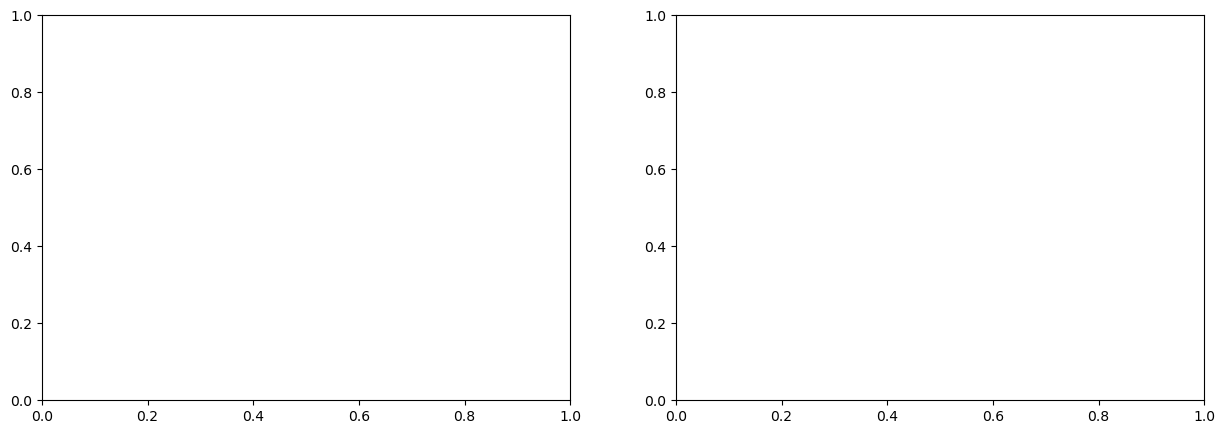

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.metrics import Precision, Recall


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and prepare the data
celltype_data = pd.read_csv('./data/train_cell_type.csv')
print(f"Dataset shape: {celltype_data.shape}")

# Explore unique cell types for our multiclass classification
unique_cell_types = celltype_data['cellType'].unique()
print(f"Unique cell types: {unique_cell_types}")
print(f"Number of unique cell types: {len(unique_cell_types)}")

# Check class distribution
class_distribution = celltype_data['cellType'].value_counts()
print("Class distribution:")
print(class_distribution)

# Using the existing cellType values (0,1,2,3) instead of encoding
n_classes = len(unique_cell_types)

# Create patient-based train-validation split using the provided function
patient_ids = celltype_data['patientID'].values
labels = celltype_data['cellType'].values

# Split into train (80%) and validation (20%)
train_mask, val_mask, train_patients, val_patients = create_simple_validation_split(
    patient_ids, labels, test_size=0.3, random_state=42
)

# Create dataframes for each set
train_df = celltype_data[train_mask]
val_df = celltype_data[val_mask]

print(f"Training set: {len(train_df)} samples from {len(train_patients)} patients")
print(f"Validation set: {len(val_df)} samples from {len(val_patients)} patients")

# Function to load and preprocess images
def load_images(dataframe, img_size=(27, 27)):
    images = []
    for img_path in dataframe['ImagePath']:
        # Check if path exists and is valid
        if os.path.exists(img_path):
            img = load_img(img_path, color_mode='rgb', target_size=img_size)
            img_array = img_to_array(img)
            images.append(img_array)
        else:
            print(f"Warning: Image not found at {img_path}")
            # Add a blank image as a placeholder
            images.append(np.zeros((img_size[0], img_size[1], 3)))
    
    return np.array(images)

# Load images
print("Loading and preprocessing images...")
X_train = load_images(train_df)
X_val = load_images(val_df)

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0

# Get labels
y_train = train_df['cellType'].values
y_val = val_df['cellType'].values

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)

print(f"Input shape: {X_train.shape}")
print(f"Output shape: {y_train_onehot.shape}")

# ======================================================
# 1. CNN MODEL IMPLEMENTATION
# ======================================================

def build_cnn_model(input_shape=(27, 27, 3), n_classes=n_classes):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    return model

# ======================================================
# 2. FULLY CONNECTED NEURAL NETWORK IMPLEMENTATION
# ======================================================

def build_fcnn_model(input_shape=(27, 27, 3), n_classes=n_classes):
    # Calculate the flattened input size
    flat_size = input_shape[0] * input_shape[1] * input_shape[2]
    
    model = models.Sequential([
        # Flatten the input images
        layers.Flatten(input_shape=input_shape),
        
        # First dense layer
        layers.Dense(1024, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Second dense layer
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Third dense layer
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(n_classes, activation='softmax')
    ])
    
    return model

# ======================================================
# MODEL TRAINING AND EVALUATION FUNCTION
# ======================================================

def train_and_evaluate_model(model, model_name, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """Train and evaluate a model with standard callbacks"""
    
    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=[Precision(), Recall()]
    )
    
    # Set up callbacks
    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor='val_loss'),
        ModelCheckpoint(f'best_{model_name}.h5', save_best_only=True, monitor='val_loss')
    ]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Plot training history
    plot_training_history(history, model_name)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    print(f"{model_name} Validation Loss: {val_loss:.4f}")
    print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")
    
    # Generate predictions
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(n_classes),
                yticklabels=range(n_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return model, history

def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Precision
    ax1.plot(history.history['precision'], label='Train Precision')
    ax1.plot(history.history['val_precision'], label='Val Precision')
    ax1.set_title(f'{model_name} Precision')
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    # Plot Recall
    ax2.plot(history.history['recall'], label='Train Recall')
    ax2.plot(history.history['val_recall'], label='Val Recall')
    ax2.set_title(f'{model_name} Recall')
    ax2.set_ylabel('Recall')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


# ======================================================
# TRAIN BOTH MODELS
# ======================================================

# Create and train CNN model
print("\n\n==== TRAINING CNN MODEL ====")
cnn_model = build_cnn_model()
cnn_model.summary()
cnn_model, cnn_history = train_and_evaluate_model(
    cnn_model, 'CNN', X_train, y_train_onehot, X_val, y_val_onehot
)

# Create and train FCNN model
print("\n\n==== TRAINING FULLY CONNECTED NEURAL NETWORK ====")
fcnn_model = build_fcnn_model()
fcnn_model.summary()
fcnn_model, fcnn_history = train_and_evaluate_model(
    fcnn_model, 'FCNN', X_train, y_train_onehot, X_val, y_val_onehot
)

# ======================================================
# HYPERPARAMETER TUNING RECOMMENDATIONS
# ======================================================

print("\n\n==== HYPERPARAMETER TUNING RECOMMENDATIONS ====")
print("""
Hyperparameter tuning recommendations for cell type classification:

1. Learning Rate:
   - Initial value: 0.001 (current setting)
   - Tuning range: [0.0001, 0.01]
   - Justification: The learning rate controls step size during optimization. 
     Too high may cause divergence, too low leads to slow convergence. The optimal 
     learning rate depends on the specific dataset characteristics and model architecture.
   - Implementation: Use ReduceLROnPlateau callback to dynamically reduce learning rate 
     when validation metrics plateau.

2. Batch Size:
   - Initial value: 32 (current setting)
   - Tuning range: [16, 64]
   - Justification: Smaller batch sizes provide more parameter updates and potentially better 
     generalization but slower training. Larger batch sizes enable better gradient estimates 
     and faster training but may lead to poorer generalization.
   - Implementation: Grid search different batch sizes and measure validation performance.

3. Network Depth:
   - CNN: Test with 2-4 convolutional blocks
   - FCNN: Test with 2-5 dense layers
   - Justification: Deeper networks can learn more complex representations but require more 
     data and are prone to overfitting. For 27x27 images, extremely deep networks may be 
     unnecessary and could lead to overfitting.

4. Dropout Rate:
   - Current values: 0.25 (convolutional layers), 0.5 (dense layers)
   - Tuning range: [0.1, 0.5]
   - Justification: Dropout is a regularization technique to prevent overfitting. The optimal 
     rate depends on model complexity and dataset size. Early layers typically need less 
     dropout than later layers.

5. Number of Filters/Neurons:
   - CNN filters: Test [16, 32, 64] for first layer, doubling in each subsequent layer
   - FCNN neurons: Test different architectures like [512, 256], [1024, 512, 256], etc.
   - Justification: The number of filters/neurons controls model capacity. Too few may 
     result in underfitting, while too many can lead to overfitting and increased computational cost.

6. Data Augmentation Parameters:
   - Rotation range: 15-30 degrees
   - Width/height shift: 0.1-0.2
   - Zoom range: 0.1-0.15
   - Horizontal/vertical flip: True/False depending on cell orientation importance
   - Justification: Data augmentation increases effective training set size and improves 
     model generalization. The parameters should be tuned to match expected variations in the data 
     while preserving class-specific features.

7. Early Stopping Patience:
   - Current value: 10 epochs
   - Tuning range: [5, 15]
   - Justification: Patience determines how many epochs to wait for improvement before stopping 
     training. Too short may stop training prematurely, while too long wastes computational resources.

8. Optimizer:
   - Current choice: Adam
   - Alternatives: RMSprop, SGD with momentum
   - Justification: Different optimizers have different convergence properties. Adam generally 
     works well for most problems, but alternatives may perform better in specific cases.

Recommended Tuning Approach:
1. Start with learning rate and batch size tuning as these often have the largest impact
2. Proceed to network architecture tuning (depth, width)
3. Fine-tune regularization parameters (dropout)
4. Optimize data augmentation parameters
5. Consider ensemble methods combining CNN and FCNN predictions for potentially better performance
""")

# Function to visualize model architecture
def visualize_model_architecture(model, model_name):
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file=f'{model_name}_architecture.png', show_shapes=True, show_layer_names=True)
    print(f"Model architecture saved as {model_name}_architecture.png")

# Uncomment to visualize model architectures
# visualize_model_architecture(cnn_model, 'CNN')
# visualize_model_architecture(fcnn_model, 'FCNN')

# ======================================================
# DATA AUGMENTATION IMPLEMENTATION (FOR REFERENCE)
# ======================================================

print("\n\n==== DATA AUGMENTATION IMPLEMENTATION ====")
print("""
# Example implementation of data augmentation:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,           # Random rotations (0-20 degrees)
    width_shift_range=0.15,      # Random horizontal shifts
    height_shift_range=0.15,     # Random vertical shifts
    zoom_range=0.15,             # Random zoom
    horizontal_flip=True,        # Random horizontal flips
    vertical_flip=False,         # No vertical flips (cell orientation may matter)
    fill_mode='nearest'          # Strategy for filling points outside the input boundaries
)

# Fit the generator on the training data
datagen.fit(X_train)

# Train using the generator
model.fit(
    datagen.flow(X_train, y_train_onehot, batch_size=32),
    validation_data=(X_val, y_val_onehot),
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    callbacks=callbacks
)
""")

# Save final models
cnn_model.save('final_cnn_model.h5')
fcnn_model.save('final_fcnn_model.h5')
print("Models saved successfully!")

## Using extra data to improve the current accuracy

Analysis on the given data: 
The given data does not have the labels for the cell type but only with the cancerous status. So, one possible way is to train the embeddings via the encoder/decoder neural network (i.e. similar to what BERT do), then fine tuned on the given dataset. 

Running the transfer learning: https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets
